### 1. Import all the libraries and read the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import lightgbm as lgb
import xgboost as xgb
from Utils.calculate_metrics import calculate_multiclass_metrics

from joblib import dump, load
import warnings

warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('./Data/train.csv', index_col='id')
test_data = pd.read_csv('./Data/test.csv', index_col='id')
train_data.shape, test_data.shape

((7200, 139), (800, 139))

### 2. Data preprocessing and Feature Engineering

In [3]:
def preprocess_data_base(data: pd.DataFrame):
    data = data.copy()
    data = data[data["happiness"] > 0]
    
    data.loc[:, "survey_month"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[1]).astype("int64")
    data.loc[:, "survey_day"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[2]).astype("int64")
    data.loc[:, "survey_hour"] = data["survey_time"].apply(lambda line: line.split(" ")[1].split(":")[0]).astype("int64")
    data = data.drop(columns='survey_time')
    
    data = data.drop(columns=['edu_other', 'property_other', 'invest_other', 'join_party'])
    data = data.fillna(0)
    
    label = data.pop('happiness')
    return data, label

def preprocess_data_relevance(train_data: pd.DataFrame, selected_features: list = None) -> pd.DataFrame:
    data = train_data.copy()
    data = data[data["happiness"] > 0]
    
    # Feature engineering
    data.loc[:, "survey_month"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[1]).astype("int64")
    data.loc[:, "survey_day"] = data["survey_time"].apply(lambda line: line.split(" ")[0].split("/")[2]).astype("int64")
    data.loc[:, "survey_hour"] = data["survey_time"].apply(lambda line: line.split(" ")[1].split(":")[0]).astype("int64")
    data.loc[:, "age"] = 2015 - data["birth"]

    data = data.drop(columns='survey_time')
    data = data.drop(columns=['edu_other', 'property_other', 'invest_other', 'join_party'])

    # Replace NaN in specific columns with 0
    for column in ['work_status', 'work_yr', 'work_type', 'work_manage', 's_work_status', 's_work_type']:
        data.loc[data[column].isna(), column] = 0
    
    # Replace remaining NaN values with mode
    data = data.fillna(data.mode().iloc[0])

    # Replace negative values with the mode for integer columns
    for column in data.columns:
        if data[column].dtype == np.int64:
            data.loc[data[column] < 0, column] = data[column].mode().iloc[0]
    
    if selected_features is None:
        corr_matrix = data.corr(method='pearson', numeric_only=True)['happiness'][abs(data.corr(method='pearson', numeric_only=True)['happiness'])>0.05]
        features = corr_matrix.index.values.tolist()
        features.extend(['age'])  # Adding age explicitly as it is not necessarily part of correlation
        data_selected = data[features]
    else:
        selected_features.append('happiness')
        data_selected = data[selected_features]  # Ensure the selected features match

    label = data_selected.pop('happiness')
    return data_selected, label

def preprocess_data_precise(train_data):
    
    required_list = ['survey_type', 'province', 'city', 'county', 'survey_time', 'gender', 'birth', 'nationality', 'religion',
                    'religion_freq', 'edu', 'income', 'political', 'floor_area', 'height_cm', 'weight_jin', 'health', 'health_problem',
                    'depression', 'hukou', 'socialize', 'relax', 'learn', 'equity', 'class', 'work_exper', 'work_status', 'work_yr', 'work_type',
                    'work_manage', 'family_income', 'family_m', 'family_status', 'house', 'car', 'marital', 'status_peer', 'status_3_before', 
                    'view', 'inc_ability']
    continuous_list = ['birth', 'edu_yr', 'income', 'floor_area', 'height_cm', 'weight_jin', 'work_yr', 'family_income', 'family_m', 'house', 'son', 
                    'daughter', 'minor_child', 'marital_1st', 's_birth', 'marital_now', 's_income', 'f_birth', 'm_birth', 'inc_exp',
                    'public_service_1', 'public_service_2', 'public_service_3', 'public_service_4', 'public_service_5', 'public_service_6',
                    'public_service_7', 'public_service_8', 'public_service_9']
    categorical_list = ['survey_type', 'province', 'gender', 'nationality']

    train_data.drop((train_data[train_data[required_list].isna().sum(axis=1) > 0])[(train_data[train_data[required_list].isna().sum(axis=1) > 0].work_exper == 1)].index, inplace=True)
    train_data.drop(train_data['family_income'].isna()[train_data['family_income'].isna()].index, inplace=True)
    train_data.drop(train_data[(train_data['edu_status'] == 4) & (train_data['edu_yr'].isna())].index, inplace=True)

    train_data[np.array(train_data['minor_child'].isna())].loc[:, 'son':'daughter']

    train_data['minor_child'].fillna(0, inplace=True)

    train_data.drop(train_data[train_data['s_birth'].isna()]['marital'][train_data[train_data['s_birth'].isna()]['marital'] == 2].index, inplace=True)
    train_data.drop(train_data[train_data['marital_now'].isna()].loc[train_data[train_data['marital_now'].isna()]['marital'] == 3].index, inplace=True)

    train_data.drop(train_data[train_data['edu_other'].isna()][train_data[train_data['edu_other'].isna()]['edu'] == 14].index, inplace=True)
    train_data.drop(train_data[train_data['edu_status'].isna()][train_data[train_data['edu_status'].isna()]['edu'] == 3].index, inplace=True)

    train_data.drop(train_data[train_data['join_party'].isna()][train_data[train_data['join_party'].isna()]['political'] == 4].index, inplace=True)

    train_data['social_neighbor'].fillna(1, inplace=True)
    train_data['social_friend'].fillna(1, inplace=True)

    train_data.drop(train_data[train_data['s_work_status'].isna()][train_data[train_data['s_work_status'].isna()]['s_work_exper'] == 1].index, inplace=True)

    no_ne_rows_index = (train_data.drop(['survey_time', 'edu_other', 'property_other', 'invest_other'], axis=1) < 0).sum(axis=1)[(train_data.drop(['survey_time', 'edu_other', 'property_other', 'invest_other'], axis=1) < 0).sum(axis=1) == 0].index
    for column, content in train_data.items():
        if pd.api.types.is_numeric_dtype(content):
            train_data[column] = train_data[column].apply(lambda x : pd.Series(train_data.loc[no_ne_rows_index, :][column].unique()).median() if(x < 0 and x != np.nan) else x)
    train_data.fillna(-1, inplace=True)

    train_data['edu_other'] = train_data['edu_other'].astype('category').values.codes + 1
    
    # property_other
    # train_data[train_data['property_other'] != -1]['property_other'].to_frame()
    train_data.drop(columns=['property_other'], inplace=True)
    train_data['invest_other'] = train_data['invest_other'].astype('category').values.codes + 1
    data_nona = train_data.copy()
    data_nona.drop(data_nona[data_nona['house'] > 25].index, inplace=True)
    data_nona.drop(data_nona[data_nona['family_m'] > 40].index, inplace=True)
    data_nona.drop(data_nona[data_nona['inc_exp'] > 0.6e8].index, inplace=True)
    
    data_nona['survey_time'] = pd.to_datetime(data_nona['survey_time'])
    data_nona.drop(data_nona[data_nona['survey_time'].dt.month < 6].index, inplace=True)

    ## change the survey_time back to M8[ns]
    data_nona['survey_time'] = data_nona['survey_time'].astype('int64')
    
    
    for column in continuous_list:
        cut = pd.qcut(data_nona[column], q=5, duplicates='drop')
        cat = cut.values
        codes = cat.codes
        data_nona[column + '_discrete'] = codes

    for column, content in data_nona.items():
        if pd.api.types.is_numeric_dtype(content):
            data_nona[column] = content.astype('int')


    data_nona.drop(columns=continuous_list, axis = 1, inplace=True)
    label = data_nona.pop('happiness')
    
    return data_nona, label


In [4]:
train_df_base, train_label_base = preprocess_data_base(train_data)
test_df_base, test_label_base = preprocess_data_base(test_data)

train_df_relevance, train_label_relevance = preprocess_data_relevance(train_data)
test_df_relevance, test_label_relevance = preprocess_data_relevance(test_data, selected_features=train_df_relevance.columns.tolist())




train_df_base.shape, train_df_relevance.shape

((7190, 136), (7190, 75))

In [5]:
train_df_precise, train_label_precise = preprocess_data_precise(train_data)
test_df_precise, test_label_precise = preprocess_data_precise(test_data)

### 3. Basic Modeling:

#### 3.1 Support Vector Machine (SVM)

**Our observations:**

- SVM can't handle such complex cases. It tends to predict the majority class (Happiness = 4).
- PCA can't improve the performance of SVM.

**Conclusion:** SVM is not a good choice for this dataset.

In [5]:
from sklearn import svm
from sklearn import metrics

svc_rbf1 = svm.SVC(kernel='rbf', C=1)
svc_rbf2 = svm.SVC(kernel='rbf', C=1)

svc_rbf1.fit(train_df_base, train_label_base)
svc_rbf2.fit(train_df_relevance, train_label_relevance)

predict_base = svc_rbf1.predict(test_df_base)
predict_relevance = svc_rbf2.predict(test_df_relevance)



metric1 = calculate_multiclass_metrics(test_label_base, predict_base, [1, 2, 3, 4, 5])
metric2 = calculate_multiclass_metrics(test_label_relevance, predict_relevance, [1, 2, 3, 4, 5])
metric1, metric2


({'MSE': 0.7894736842105263,
  'Accuracy': 0.5726817042606517,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 671, 'FP': 1, 'FN': 126},
   4: {'TP': 457, 'TN': 0, 'FP': 340, 'FN': 1},
   5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
  'Unrounded MSE': 0.7894736842105263},
 {'MSE': 0.7882205513784462,
  'Accuracy': 0.5739348370927319,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 672, 'FP': 0, 'FN': 126},
   4: {'TP': 458, 'TN': 0, 'FP': 340, 'FN': 0},
   5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
  'Unrounded MSE': 0.7882205513784462})

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)
reduced_train = pca.fit_transform(train_df_base)
reduced_test = pca.fit_transform(test_df_base)

print(reduced_train.shape, reduced_test.shape)

svc_rbf = svm.SVC(kernel='rbf')
svc_rbf.fit(reduced_train, train_label_base)

predict = svc_rbf.predict(reduced_test)

mse = metrics.mean_squared_error(test_label_base, predict)
accuracy = metrics.accuracy_score(test_label_base, predict)

print('MSE:', mse, end=' ')
print('Accuracy:', accuracy)

np.where(predict!=4)

(7190, 4) (798, 4)
MSE: 0.7894736842105263 Accuracy: 0.5726817042606517


(array([666]),)

### 3.2 Ridge Regression

**Our observations:**
- Betther than SVM when it comes to the mse. 
- Perform poorly in terms of the accuracy.
- It seems underfit or the model is too simple for this dataset. We try to evaluate the model with training data but the model is not able to capture the complexity of the data.

**Conclusion:**
Ridge Regression is not a good choice for this dataset.

In [20]:
from sklearn import linear_model

ridge1 = linear_model.Ridge()
ridge2 = linear_model.Ridge()
ridge3 = linear_model.Ridge()

ridge1.fit(train_df_base, train_label_base)
ridge2.fit(train_df_relevance, train_label_relevance)

predict_base = ridge1.predict(test_df_base)
predict_relevance = ridge2.predict(test_df_relevance)

metric1 = calculate_multiclass_metrics(test_label_base, predict_base, [1, 2, 3, 4, 5])
metric2 = calculate_multiclass_metrics(test_label_relevance, predict_relevance, [1, 2, 3, 4, 5])

metric1, metric2


({'MSE': 0.6265664160401002,
  'Accuracy': 0.5764411027568922,
  'Class Metrics': {1: {'TP': 0, 'TN': 783, 'FP': 1, 'FN': 14},
   2: {'TP': 1, 'TN': 736, 'FP': 3, 'FN': 58},
   3: {'TP': 47, 'TN': 565, 'FP': 107, 'FN': 79},
   4: {'TP': 393, 'TN': 122, 'FP': 218, 'FN': 65},
   5: {'TP': 19, 'TN': 648, 'FP': 9, 'FN': 122}},
  'Unrounded MSE': 0.5970765370129141},
 {'MSE': 0.5827067669172933,
  'Accuracy': 0.5764411027568922,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 735, 'FP': 4, 'FN': 59},
   3: {'TP': 45, 'TN': 562, 'FP': 110, 'FN': 81},
   4: {'TP': 389, 'TN': 127, 'FP': 213, 'FN': 69},
   5: {'TP': 26, 'TN': 646, 'FP': 11, 'FN': 115}},
  'Unrounded MSE': 0.536173360532307})

### 3.3 Logistic Regression

**Our observations:**
- Similar to SVM, Logistic Regression can't handle such complex cases. It tends to predict the majority class (Happiness = 4).
- PCA will even make the performance worse.

**Conclusion:** 
Logistic Regression is not a good choice for this dataset.

In [13]:
from sklearn import linear_model    
from sklearn import metrics

logistic1 = linear_model.LogisticRegression()
logistic2 = linear_model.LogisticRegression()

logistic1.fit(train_df_base, train_label_base)
logistic2.fit(train_df_relevance, train_label_relevance)

predict_base = logistic1.predict(test_df_base)
predict_relevance = logistic2.predict(test_df_relevance)

metric1 = calculate_multiclass_metrics(test_label_base, predict_base, [1, 2, 3, 4, 5])
metric2 = calculate_multiclass_metrics(test_label_relevance, predict_relevance, [1, 2, 3, 4, 5])

metric1, metric2

({'MSE': 0.7944862155388471,
  'Accuracy': 0.5714285714285714,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 738, 'FP': 1, 'FN': 59},
   3: {'TP': 0, 'TN': 671, 'FP': 1, 'FN': 126},
   4: {'TP': 456, 'TN': 0, 'FP': 340, 'FN': 2},
   5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
  'Unrounded MSE': 0.7944862155388471},
 {'MSE': 0.7882205513784462,
  'Accuracy': 0.5739348370927319,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 0, 'TN': 739, 'FP': 0, 'FN': 59},
   3: {'TP': 0, 'TN': 672, 'FP': 0, 'FN': 126},
   4: {'TP': 458, 'TN': 0, 'FP': 340, 'FN': 0},
   5: {'TP': 0, 'TN': 657, 'FP': 0, 'FN': 141}},
  'Unrounded MSE': 0.7882205513784462})

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 8)
reduced_train = pca.fit_transform(train_df_base)
reduced_test = pca.fit_transform(test_df_base)

logistic = linear_model.LogisticRegression()
logistic.fit(reduced_train, train_label_base)

predict = logistic.predict(reduced_test)

mse = metrics.mean_squared_error(test_label_base, predict)
accuracy = metrics.accuracy_score(test_label_base, predict)

print('MSE:', mse, end=' ')
print('Accuracy:', accuracy)



MSE: 1.3922305764411027 Accuracy: 0.4523809523809524


### 4. Advanced Modeling:

### 4.1 LightGBM

**Our observations:**


**Conclusion:**

In [5]:
import lightgbm as lgb
from sklearn import metrics
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

lgbR1 = lgb.LGBMRegressor(n_estimators=10000)
lgbR2 = lgb.LGBMRegressor(n_estimators=10000)


lgbR1.fit(train_df_base, train_label_base)
lgbR2.fit(train_df_relevance, train_label_relevance)

predict_base = lgbR1.predict(test_df_base)
predict_relevance = lgbR2.predict(test_df_relevance)

metric1 = calculate_multiclass_metrics(test_label_base, predict_base, [1, 2, 3, 4, 5])
metric2 = calculate_multiclass_metrics(test_label_relevance, predict_relevance, [1, 2, 3, 4, 5])

metric1, metric2




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3077
[LightGBM] [Info] Number of data points in the train set: 7190, number of used features: 132
[LightGBM] [Info] Start training from score 3.873435
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 7190, number of used features: 75
[LightGBM] [Info] Start training from score 3.873435


({'MSE': 0.6228070175438597,
  'Accuracy': 0.5776942355889725,
  'Class Metrics': {1: {'TP': 1, 'TN': 784, 'FP': 0, 'FN': 13},
   2: {'TP': 7, 'TN': 726, 'FP': 13, 'FN': 52},
   3: {'TP': 53, 'TN': 573, 'FP': 99, 'FN': 73},
   4: {'TP': 380, 'TN': 136, 'FP': 204, 'FN': 78},
   5: {'TP': 20, 'TN': 636, 'FP': 21, 'FN': 121}},
  'Unrounded MSE': 0.5550902570811506},
 {'MSE': 0.6453634085213033,
  'Accuracy': 0.5651629072681704,
  'Class Metrics': {1: {'TP': 1, 'TN': 784, 'FP': 0, 'FN': 13},
   2: {'TP': 10, 'TN': 722, 'FP': 17, 'FN': 49},
   3: {'TP': 49, 'TN': 572, 'FP': 100, 'FN': 77},
   4: {'TP': 364, 'TN': 141, 'FP': 199, 'FN': 94},
   5: {'TP': 27, 'TN': 626, 'FP': 31, 'FN': 114}},
  'Unrounded MSE': 0.5791230813602934})


Feature Importance (Base):
           feature  importance
14      floor_area       10509
134     survey_day        8559
25      weight_jin        7841
24       height_cm        7387
69   family_income        7277
..             ...         ...
21      property_6           9
79        invest_5           0
80        invest_6           0
81        invest_7           0
82        invest_8           0

[136 rows x 2 columns]


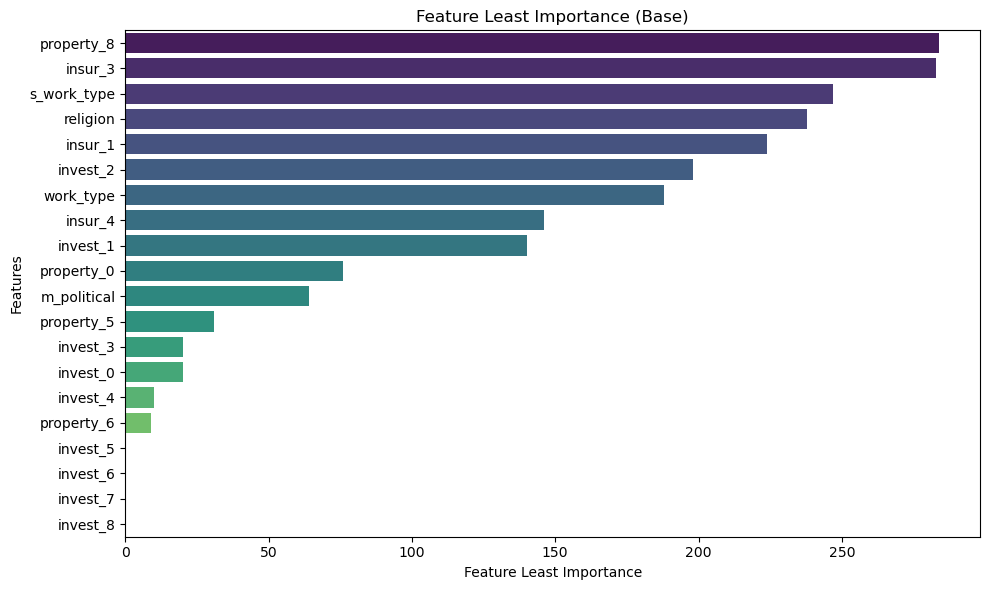

In [11]:
import seaborn as sns

importance_base = pd.DataFrame({
    'feature': train_df_base.columns,
    'importance': lgbR1.feature_importances_
}).sort_values(by='importance', ascending=False)

importance_relevance = pd.DataFrame({
    'feature': train_df_relevance.columns,
    'importance': lgbR2.feature_importances_
}).sort_values(by='importance', ascending=False)

# 打印结果

print("\nFeature Importance (Base):")
print(importance_base)

def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="importance", 
        y="feature", 
        data=importance_df.tail(20),  # 展示前 20 个最重要特征
        palette="viridis"
    )
    plt.title(title)
    plt.xlabel("Feature Least Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
plot_feature_importance(importance_base, "Feature Least Importance (Base)")


In [9]:
lgbr3 = lgb.LGBMRegressor(num_leaves=7,min_data_in_leaf=20,objective='regression',max_depth=-1,learning_rate=0.003,
                              boosting='gbdt',feature_fraction=0.18,bagging_freq=1,bagging_fraction=0.55,bagging_seed=14,
                              metric='mse',lambda_l1=0.1,lambda_l2=0.2,verbosity=-1, n_estimators=10000)

lgbr3.fit(train_df_precise, train_label_precise)
predict_precise = lgbr3.predict(test_df_precise)
metric_precise = calculate_multiclass_metrics(test_label_precise, predict_precise, [1, 2, 3, 4, 5])

metric_precise

{'MSE': 0.5776942355889725,
 'Accuracy': 0.5852130325814536,
 'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
  2: {'TP': 3, 'TN': 731, 'FP': 8, 'FN': 56},
  3: {'TP': 51, 'TN': 571, 'FP': 99, 'FN': 77},
  4: {'TP': 393, 'TN': 124, 'FP': 218, 'FN': 63},
  5: {'TP': 20, 'TN': 651, 'FP': 6, 'FN': 121}},
 'Unrounded MSE': 0.5265001708733944}

In [11]:
import lightgbm as lgb
from sklearn import metrics

clf_lightgbm_modified=lgb.LGBMRegressor(metric='l2',colsample_bytree=0.8,learning_rate=0.1,
                                             max_depth=7,min_child_weight=0,min_split_gain=0.1,
                                             reg_alpha=1,reg_lambda=0.0001,subsample=0.5, n_estimators=10000)   

clf_lightgbm_modified.fit(train_df_base, train_label_base)

predict = clf_lightgbm_modified.predict(test_df_base)
predict = np.round(predict)
mse = metrics.mean_squared_error(test_label_base, predict)
# accuracy = metrics.accuracy_score(test_label_precise, predict)

print('MSE:', mse, end=' ')
# print('Accuracy:', accuracy)


MSE: 0.5877192982456141 

#### 4.2 XGBoost

**Our observations:**



**Conclusion:**

In [17]:
import xgboost as xgb


xgboost1 = xgb.XGBRegressor()
xgboost2 = xgb.XGBRegressor()


xgboost1.fit(train_df_base, train_label_base)
xgboost2.fit(train_df_relevance, train_label_relevance)

predict_base = xgboost1.predict(test_df_base)
predict_relevance = xgboost2.predict(test_df_relevance)

metric1 = calculate_multiclass_metrics(test_label_base, predict_base, [1, 2, 3, 4, 5])
metric2 = calculate_multiclass_metrics(test_label_relevance, predict_relevance, [1, 2, 3, 4, 5])

metric1, metric2

({'MSE': 0.6604010025062657,
  'Accuracy': 0.5626566416040101,
  'Class Metrics': {1: {'TP': 0, 'TN': 784, 'FP': 0, 'FN': 14},
   2: {'TP': 10, 'TN': 728, 'FP': 11, 'FN': 49},
   3: {'TP': 55, 'TN': 565, 'FP': 107, 'FN': 71},
   4: {'TP': 360, 'TN': 145, 'FP': 195, 'FN': 98},
   5: {'TP': 24, 'TN': 621, 'FP': 36, 'FN': 117}},
  'Unrounded MSE': 0.6030856177106182},
 {'MSE': 0.6290726817042607,
  'Accuracy': 0.5651629072681704,
  'Class Metrics': {1: {'TP': 1, 'TN': 783, 'FP': 1, 'FN': 13},
   2: {'TP': 8, 'TN': 727, 'FP': 12, 'FN': 51},
   3: {'TP': 49, 'TN': 573, 'FP': 99, 'FN': 77},
   4: {'TP': 368, 'TN': 138, 'FP': 202, 'FN': 90},
   5: {'TP': 25, 'TN': 625, 'FP': 32, 'FN': 116}},
  'Unrounded MSE': 0.5711537677684208})

#### 4.3 LightGBM Essambled with XGBoost

In [19]:
from sklearn import metrics
xgboost = xgb.XGBRegressor(max_depth=4,min_child_weight=0.5,gamma=0.4,subsample=0.7,colsample_bytree=0.8,reg_alpha=1,reg_lambda=0.001)   
lgbm = lgb.LGBMRegressor(metric='l2',colsample_bytree=0.8,learning_rate=0.1,
                                             max_depth=7,min_child_weight=0,
                                             reg_alpha=1,reg_lambda=0.0001,subsample=0.5)   

xgboost.fit(train_df_relevance, train_label_relevance)
lgbm.fit(train_df_relevance, train_label_relevance)

predict_xgboost = xgboost.predict(test_df_relevance)
predict_lgbm = lgbm.predict(test_df_relevance)

predict = (predict_xgboost + predict_lgbm) / 2

predict = np.round(predict)
mse = metrics.mean_squared_error(test_label_relevance, predict)
accuracy = metrics.accuracy_score(test_label_relevance, predict)

print('MSE:', mse, end=' ')
    
print('Accuracy:', accuracy)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 7190, number of used features: 75
[LightGBM] [Info] Start training from score 3.873435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 